In [30]:
# # install once
# from google.colab import drive
# drive.mount('/content/drive')
# # !pip install -e /content/drive/MyDrive/FDFL/Fairness-Decision-Focused-Loss/Organized-FDFL

In [31]:
# import sys
# sys.path.append('/content/drive/MyDrive/FDFL/Fairness-Decision-Focused-Loss/Organized-FDFL')

In [32]:
from src.utils.myOptimization import (
    AlphaFairness, AlphaFairnesstorch,
    solveIndProblem, solve_closed_form,
    solve_group, compute_coupled_group_obj,
    solve_group_grad, compute_gradient_closed_form,
    compute_group_gradient_analytical, solve_d_and_gradient_analytical
)
from src.utils.myPrediction import generate_random_features, customPredictionModel
from src.utils.plots import visLearningCurve
from src.fairness.cal_fair_penalty import atkinson_loss, mean_abs_dev, compute_group_accuracy_parity
from src.utils.features import get_all_features

import numpy as np
import pandas as pd
import cvxpy as cp
import torch
import torch.nn as nn
from torch.autograd import Function
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
import warnings
import time
import itertools
from dataclasses import dataclass, field
from typing import List, Dict, Any
import json
from torch.utils.data import Dataset
import time
import torch
import torch.nn as nn
import numpy as np
import cvxpy as cp
from torch.autograd import Function
import torch.nn.functional as F
import copy

warnings.filterwarnings("ignore")

In [33]:
%%script echo skipping

print(1)

Couldn't find program: 'echo'


# Import Data


In [34]:
# Save to json

params = {
    "n_sample": 5000 ,
    "alpha": 2,
    "Q": 1000,
    "epochs": 50,
    "lambdas": 1.0,
    "lr": 0.01
}
n_sample = params["n_sample"]
alpha    = params["alpha"]
Q        = params["n_sample"]//2
epochs   = params["epochs"]
lambdas  = params["lambdas"]
lr       = params["lr"]
print(Q)

# df = pd.read_csv('/Users/dennis/Downloads/2024-fall/research/Fairness-Decision-Focused-Loss/Organized-FDFL/src/data/data.csv')

df = pd.read_csv(r'E:\myREPO\Fairness-Decision-Focused-Loss\Organized-FDFL\src\data\data.csv')
df = df.sample(n=n_sample,random_state=42)

# Normalized cost to 1-10 range
cost = np.array(df['cost_t_capped'].values) * 10
cost = np.maximum(cost, 1)

# All features, standardized
features = df[get_all_features(df)].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# True benefit, predictor label normalzied to 1-100 range (add 1 to avoid error)
benefit = np.array(df['benefit'].values) * 100
benefit = np.maximum(benefit, 1)
benefit = benefit + 1

# Group labels, 0 is White (Majority), 1 is Black
race = np.array(df['race'].values)

gainF = np.ones_like(benefit)

2500


In [35]:
print(df['race'].value_counts())

race
0    4422
1     578
Name: count, dtype: int64


# Prediction Model

In [36]:
# class FairRiskPredictor(nn.Module):
#     def __init__(self, input_dim, dropout_rate=0.1):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, 1),
#             nn.Softplus()
#         )

#     def forward(self, x):
#         return self.model(x).squeeze(-1)

In [37]:
class FairRiskPredictor(nn.Module):
    """
    An improved predictor model featuring Batch Normalization for stability
    and Kaiming (He) weight initialization for faster convergence.
    """
    def __init__(self, input_dim, dropout_rate=0.2, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # The squeeze operation is now done in the training loop for clarity
        return self.model(x)

In [38]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Softplus()
        )

    def forward(self, x):
        return self.model(x)

## JVP calculation (test)

In [39]:
# def solve_coupled_group_jvp(b, c, group_idx, Q, alpha, beta, v):
#     """
#     Computes the vector-Jacobian product v @ J for the coupled group-alpha problem
#     without explicitly forming the full Jacobian matrix J.
#     Complexity: O(n) for each element of the output, avoiding O(n^2).
#     """
#     # Ensure inputs are NumPy arrays
#     b, c, group_idx, v = map(np.asarray, [b, c, group_idx, v])
#     n = len(b)
#     final_grad = np.zeros(n)

#     # --- 1. Forward Pass: Pre-compute terms from the solver ---
#     # This part is identical to the start of the original _grad function
#     if beta > 1:
#         gamma = beta - 2 + alpha - alpha * beta
#         psi_s_exp_factor = (2 - alpha) / gamma
#     else: # beta < 1
#         gamma = beta + alpha - alpha * beta
#         psi_s_exp_factor = -alpha / gamma

#     d_star = solve_group(b, c, group_idx, Q, alpha, beta)
#     unique_groups = np.unique(group_idx)
#     S, H, Psi = {}, {}, {}
#     for k in unique_groups:
#         mask = (group_idx == k)
#         G_k, b_k, c_k = np.sum(mask), b[mask], c[mask]
#         S[k] = np.sum((c_k**(-(1-beta)/beta)) * (b_k**((1-beta)/beta)))
#         H[k] = np.sum((c_k**((beta-1)/beta)) * (b_k**((1-beta)/beta)))
#         const_factor = (beta - 1) if beta > 1 else (1 - beta)
#         if beta > 1:
#             Psi[k] = (S[k]**psi_s_exp_factor) * (const_factor**((alpha-2)/gamma))
#         else:
#             Psi[k] = (G_k**((alpha-1)/gamma)) * (S[k]**psi_s_exp_factor) * (const_factor**(alpha/gamma))
#     Xi = np.sum([H[k] * Psi[k] for k in unique_groups])
#     phi_all = (c**(-1/beta)) * (b**((1-beta)/beta))

#     # --- 2. Compute the scalar term `Σᵢ vᵢ * dᵢ*` ---
#     v_dot_d_star = np.dot(v, d_star)

#     # --- 3. Backward Pass: Loop through each prediction `b_j` to get the j-th grad component ---
#     for j in range(n):
#         m = group_idx[j] # Group of the variable b_j

#         # --- Calculate `∂Ξ/∂bⱼ` (same as before) ---
#         dS_m_db_j = ((1-beta)/beta) * (c[j]**(-(1-beta)/beta)) * (b[j]**((1-2*beta)/beta))
#         dH_m_db_j = ((1-beta)/beta) * (c[j]**((beta-1)/beta)) * (b[j]**((1-2*beta)/beta))
#         dPsi_m_db_j = (psi_s_exp_factor / S[m]) * Psi[m] * dS_m_db_j
#         dXi_db_j = dH_m_db_j * Psi[m] + H[m] * dPsi_m_db_j

#         # --- Calculate the JVP-specific term `Σᵢ vᵢ * (∂Nᵢ/∂bⱼ)` ---
#         # ∂Nᵢ/∂bⱼ = Q * ( (∂Ψₖ/∂bⱼ) * φᵢ + Ψₖ * (∂φᵢ/∂bⱼ) )
#         # We need to sum vᵢ * (∂Nᵢ/∂bⱼ) over all i
#         sum_v_dN_db_j = 0
#         dphi_j_db_j = ((1-beta)/beta) * (c[j]**(-1/beta)) * (b[j]**((1-2*beta)/beta))

#         # The derivative ∂Ψₖ/∂bⱼ is only non-zero if k == m
#         # The derivative ∂φᵢ/∂bⱼ is only non-zero if i == j
#         # This makes the sum sparse and efficient to compute
#         sum_v_dN_db_j += Q * dPsi_m_db_j * np.dot(v[group_idx == m], phi_all[group_idx == m])
#         sum_v_dN_db_j += Q * Psi[m] * v[j] * dphi_j_db_j

#         # --- 4. Assemble the final gradient component ---
#         final_grad[j] = (1/Xi) * sum_v_dN_db_j - (dXi_db_j / Xi) * v_dot_d_star

#     return final_grad

# Dataloader

In [40]:

def to_numpy_1d(x):
    """Return a 1-D NumPy array; error if the length is not > 1."""
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    x = np.asarray(x).reshape(-1)
    assert x.ndim == 1, f"expected 1-D, got shape {x.shape}"
    return x

class optDataset(Dataset):
    def __init__(self, feats, risk, gainF, cost, race, alpha=alpha, Q=Q):
        # Store as numpy arrays for now
        self.feats = feats
        self.risk = risk
        self.gainF = gainF
        self.cost = cost
        self.race = race


        # Call optmodel (expects numpy arrays)
        sol_group = solve_group(self.risk, self.cost, self.race, Q=Q, alpha=alpha)
        obj_group = compute_coupled_group_obj(sol_group, self.risk, self.race, alpha=alpha)

        sol_ind, _ = solve_closed_form(self.gainF, self.risk, self.cost, alpha=alpha, Q=Q)

        obj_ind = AlphaFairness(self.risk*sol_ind,alpha=alpha)

        # Convert everything to torch tensors for storage
        self.feats = torch.from_numpy(self.feats).float()
        self.risk = torch.from_numpy(self.risk).float()
        self.gainF = torch.from_numpy(self.gainF).float()
        self.cost = torch.from_numpy(self.cost).float()
        self.race = torch.from_numpy(self.race).float()
        self.sol_ind = torch.from_numpy(sol_ind).float()
        self.sol_group = torch.from_numpy(sol_group).float()

        # to array
        obj_group = np.array(obj_group)
        self.obj_group = torch.from_numpy(obj_group).float()
        self.obj_ind = torch.tensor(obj_ind).float()

    def __len__(self):
        return len(self.feats)

    # def __getitem__(self, idx):
    #     return self.feats, self.risk, self.gainF, self.cost, self.race, self.sol, self.obj

    def __getitem__(self, idx):
        return (
            self.feats[idx],
            self.risk[idx],
            self.gainF[idx],
            self.cost[idx],
            self.race[idx],
            self.sol_ind[idx],
            self.sol_group[idx],
            self.obj_group,
            self.obj_ind
        )


In [41]:
optmodel_group = solve_group
optmodel_ind = solve_closed_form

# Perform train-test split
feats_train, feats_test, gainF_train, gainF_test, b_train, b_test, cost_train, cost_test, race_train, race_test = train_test_split(
    features, gainF, benefit, cost, df['race'].values, test_size=0.5, random_state=2
)

print(f"Train size: {feats_train.shape[0]}")
print(f"Test size: {feats_test.shape[0]}")

dataset_train = optDataset(feats_train, b_train, gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
dataset_test = optDataset(feats_test, b_test, gainF_test, cost_test, race_test, alpha=alpha, Q=Q)


dataloader_train = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_train), shuffle=False)

predmodel = FairRiskPredictor(feats_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predmodel.to(device)


# Get a batch from the dataloader
for batch in dataloader_train:
    names = [
        "feats", "risk", "gainF", "cost", "race",
        "sol_ind", "sol_group", "obj_group", "obj_ind"
    ]
    for name, item in zip(names, batch):
        # Only show first five elements for feats
        if name == "feats":
            print(f"First five {name}: {item[:1, :5]}")
        else:
            print(f"{name}: {item[:1]}")
    break

Train size: 2500
Test size: 2500
First five feats: tensor([[-1.3127, -0.1998, -0.3537, -0.4862,  1.7943]])
risk: tensor([2.])
gainF: tensor([1.])
cost: tensor([1.])
race: tensor([0.])
sol_ind: tensor([1.4361])
sol_group: tensor([1.4361])
obj_group: tensor([-606.0760])
obj_ind: tensor([-606.0760])


In [42]:


def _calculate_loss_and_decision(pred_r, true_r, gainF, cost, race, Q, alpha, lambdas, fairness_type, group, **kwargs):
    """
    Helper function to compute loss. Detaches inputs to prevent this logic from being part of the graph,
    as its gradient is handled manually in the backward pass.
    """
    # Use detached tensors for calculation
    pred_r_d, true_r_d, gainF_d, cost_d, race_d = map(
        lambda t: t.detach(), [pred_r, true_r, gainF, cost, race]
    )
    pred_r_np, true_r_np, gainF_np, cost_np, race_np = map(to_numpy_1d, [pred_r_d, true_r_d, gainF_d, cost_d, race_d])

    try:
        if group:
            d_hat_np = solve_group(pred_r_np, cost_np, race_np, Q, alpha)
            d_star_np = solve_group(true_r_np, cost_np, race_np, Q, alpha)
            obj_val_at_d_hat = compute_coupled_group_obj(d_hat_np, true_r_np, race_np, alpha)
            obj_val_at_d_star = compute_coupled_group_obj(d_star_np, true_r_np, race_np, alpha)
        else:
            d_hat_np, _ = solve_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q)
            d_star_np, _ = solve_closed_form(gainF_np, true_r_np, cost_np, alpha, Q)
            obj_val_at_d_hat = AlphaFairness(true_r_np * d_hat_np, alpha)
            obj_val_at_d_star = AlphaFairness(true_r_np * d_star_np, alpha)

        # Ensure regret is not negative due to solver noise
        regret_loss = torch.tensor(max(0, obj_val_at_d_star - obj_val_at_d_hat), dtype=pred_r.dtype, device=pred_r.device)

    except (ValueError, cp.error.SolverError, np.linalg.LinAlgError) as e: # type: ignore[catch]
        print(f"Warning: Solver failed: {e}")
        return torch.tensor(0.0), torch.tensor(0.0), None

    # Use the original tensors (with graph) for fairness calculation for autograd
    fairness_penalty = torch.tensor(0.0, device=pred_r.device)
    if fairness_type != 'none':
        mode = 'between' if group else 'individual'
        if fairness_type == 'atkinson': fairness_penalty = atkinson_loss(pred_r, true_r, race=race, beta=0.5, mode=mode)
        elif fairness_type == 'mad': fairness_penalty = mean_abs_dev(pred_r, true_r, race=race, mode=mode)
        elif fairness_type == 'acc_parity' and group: fairness_penalty = compute_group_accuracy_parity(pred_r, true_r, race)

    total_loss = regret_loss + lambdas * fairness_penalty
    return total_loss, fairness_penalty, d_hat_np



# (Assuming all previous helper functions like to_numpy_1d, solvers, etc. are defined)

def _calculate_regret_and_d_hat(pred_r_np, true_r_np, gainF_np, cost_np, race_np, Q, alpha, group):
    """Helper to compute regret and the decision variable d_hat."""
    try:
        if group:
            d_hat_np = solve_group(pred_r_np, cost_np, race_np, Q, alpha)
            d_star_np = solve_group(true_r_np, cost_np, race_np, Q, alpha)
            obj_val_at_d_hat = compute_coupled_group_obj(d_hat_np, true_r_np, race_np, alpha)
            obj_val_at_d_star = compute_coupled_group_obj(d_star_np, true_r_np, race_np, alpha)
        else:
            d_hat_np, _ = solve_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q)
            d_star_np, _ = solve_closed_form(gainF_np, true_r_np, cost_np, alpha, Q)
            obj_val_at_d_hat = AlphaFairness(true_r_np * d_hat_np, alpha)
            obj_val_at_d_star = AlphaFairness(true_r_np * d_star_np, alpha)

        regret = obj_val_at_d_star - obj_val_at_d_hat
        # regret = np.log1p(np.exp(regret * 10)) / 10
        return regret, d_hat_np

    except (ValueError, cp.error.SolverError, np.linalg.LinAlgError) as e: # type: ignore[catch]
        print(f"Warning: Solver failed: {e}")
        # Return a zero regret and a placeholder for d_hat
        return 0.0, np.zeros_like(pred_r_np)


# Regret Loss nn.Module



In [43]:

class RegretLossFn(Function):
    """
    Custom autograd Function for regret with a closed-form or finite-difference gradient.
    """
    @staticmethod
    def forward(ctx, pred_r, true_r, gainF, cost, race, Q, alpha, group, grad_method, noise_std):
        # --- Loss Calculation (Regret) ---
        pred_r_np, true_r_np, gainF_np, cost_np, race_np = map(
            lambda t: to_numpy_1d(t.detach()), [pred_r, true_r, gainF, cost, race]
        )

        regret, d_hat_np = _calculate_regret_and_d_hat(pred_r_np, true_r_np, gainF_np, cost_np, race_np, Q, alpha, group)
        regret_loss = torch.tensor(regret, dtype=pred_r.dtype, device=pred_r.device)
        # regret_loss = F.softplus(torch.tensor(regret, dtype=pred_r.dtype,device=pred_r.device), beta=10)
        d_hat = torch.from_numpy(d_hat_np).to(pred_r.device, dtype=pred_r.dtype)

        # --- Save for Backward ---
        ctx.save_for_backward(pred_r, true_r, gainF, cost, race, d_hat)
        ctx.params = {'Q': Q, 'alpha': alpha, 'group': group, 'grad_method': grad_method, 'noise_std': noise_std}
        return regret_loss

    @staticmethod
    def backward(ctx, grad_output): # type: ignore[override]
        pred_r, true_r, gainF, cost, race, d_hat = ctx.saved_tensors
        params = ctx.params

        # Default to a zero gradient if anything goes wrong
        grad_regret = torch.zeros_like(pred_r)

        if d_hat is None:
            return (torch.zeros_like(pred_r),) + (None,) * 8

        try:
            grad_regret_np = np.zeros(pred_r.shape[0], dtype=np.float32)

            if params['grad_method'] == 'closed-form':
                if params['group']:
                    # HYBRID APPROACH for group=True
                    # Some helpers need Tensors, others need NumPy arrays.

                    # 1. Call Tensor-expecting function with Tensors
                    grad_obj_tensor = compute_group_gradient_analytical(d_hat, true_r, race, params['alpha'])
                    # Convert its output to NumPy
                    v_np = grad_obj_tensor.detach().cpu().numpy()

                    # 2. Convert inputs for NumPy-expecting function
                    pred_r_np = pred_r.detach().cpu().numpy()
                    cost_np = cost.detach().cpu().numpy()
                    race_np = race.detach().cpu().numpy()

                    # 3. Call NumPy-expecting function and compute final gradient
                    jac_mat_np = solve_group_grad(pred_r_np, cost_np, race_np, params['Q'], params['alpha'])
                    grad_regret_np = -(v_np @ jac_mat_np)
                else:
                    # PURE NUMPY approach for group=False (which we know works)
                    pred_r_np = pred_r.detach().cpu().numpy()
                    true_r_np = true_r.detach().cpu().numpy()
                    d_hat_np = d_hat.detach().cpu().numpy()
                    gainF_np = gainF.detach().cpu().numpy()
                    cost_np = cost.detach().cpu().numpy()

                    jac_np = compute_gradient_closed_form(gainF_np, pred_r_np, cost_np, params['alpha'], params['Q'])
                    grad_obj_wrt_d_hat_np = (true_r_np)**(1 - params['alpha']) * d_hat_np**(-params['alpha'])
                    grad_regret_np = -(grad_obj_wrt_d_hat_np @ jac_np)

                if params['noise_std'] > 0:
                    noise = np.random.normal(loc=0.0, scale=params['noise_std'], size=grad_regret_np.shape)
                    grad_regret_np += noise.astype(grad_regret_np.dtype)

            elif params['grad_method'] == 'finite-diff':
                # This whole block can be NumPy, with one exception for the group gradient helper
                pred_r_np = pred_r.detach().cpu().numpy().astype(np.float32)
                true_r_np = true_r.detach().cpu().numpy().astype(np.float32)
                d_hat_np = d_hat.detach().cpu().numpy().astype(np.float32)
                gainF_np = gainF.detach().cpu().numpy().astype(np.float32)
                cost_np = cost.detach().cpu().numpy().astype(np.float32)
                race_np = race.detach().cpu().numpy().astype(np.float32)

                if params['group']:
                    # Call the Tensor-expecting helper and convert its output to NumPy
                    grad_obj_tensor = compute_group_gradient_analytical(d_hat, true_r, race, params['alpha'])
                    grad_obj_wrt_d_hat_np = grad_obj_tensor.detach().cpu().numpy()
                else:
                    grad_obj_wrt_d_hat_np = (true_r_np)**(1 - params['alpha']) * d_hat_np**(-params['alpha'])

                # The rest of the finite-difference loop remains in NumPy
                n = len(pred_r_np)
                eps = 1e-4
                for i in range(n):
                    try:
                        h = eps * max(1.0, abs(pred_r_np[i]))
                        if h == 0: continue
                        pred_r_plus = pred_r_np.copy(); pred_r_plus[i] += h
                        pred_r_minus = pred_r_np.copy(); pred_r_minus[i] -= h

                        if params['group']:
                            d_hat_np_plus = solve_group(pred_r_plus, cost_np, race_np, params['Q'], params['alpha'])
                            d_hat_np_minus = solve_group(pred_r_minus, cost_np, race_np, params['Q'], params['alpha'])
                        else:
                            d_hat_np_plus, _ = solve_closed_form(gainF_np, pred_r_plus, cost_np, params['alpha'], params['Q'])
                            d_hat_np_minus, _ = solve_closed_form(gainF_np, pred_r_minus, cost_np, params['alpha'], params['Q'])

                        d_hat_np_plus = d_hat_np_plus.astype(np.float32)
                        d_hat_np_minus = d_hat_np_minus.astype(np.float32)
                        grad_d_wrt_ri = (d_hat_np_plus - d_hat_np_minus) / (2 * h)
                        grad_regret_np[i] = -np.dot(grad_obj_wrt_d_hat_np, grad_d_wrt_ri)
                    except Exception as loop_e:
                        print(f"Warning: Solver failed during FD at index {i}: {loop_e}. Setting grad component to 0.")
                        grad_regret_np[i] = 0.0

            # Convert the final numpy gradient back to a PyTorch tensor
            grad_regret = torch.from_numpy(grad_regret_np).to(pred_r.device, dtype=pred_r.dtype)

        except Exception as e:
            print(f"Warning: Gradient calculation failed: {e}. Returning zero grad.")
            # grad_regret is already a zero tensor, so we just proceed to the return

        return (grad_output * grad_regret, None, None, None, None, None, None, None, None, None)


class FDFLLoss(nn.Module):
    """
    Decision-Focused + Fairness Loss Module.

    Can compute loss using either custom regret or standard MSE for the primary task,
    combined with a fairness penalty.
    """
    def __init__(self, Q, alpha, lambdas, fairness_type, group, grad_method='closed-form', noise_std=0.0, loss_type='regret'):
        """
        Initializes the loss module.

        Args:
            Q, alpha, lambdas, fairness_type, group, grad_method, noise_std: Existing parameters.
            loss_type (str): The primary loss component. Can be 'regret' for decision-focused loss
                             or 'mse' for Mean Squared Error. Defaults to 'regret'.
        """
        super().__init__()
        # Validate the loss_type parameter
        if loss_type not in ['regret', 'mse']:
            raise ValueError(f"Unsupported loss_type: '{loss_type}'. Must be 'regret' or 'mse'.")

        self.Q, self.alpha, self.lambdas = Q, alpha, lambdas
        self.fairness_type, self.group, self.loss_type = fairness_type, group, loss_type
        self.grad_method, self.noise_std = grad_method, noise_std

    def forward(self, pred_r, true_r, gainF, cost, race):
        # 1. Primary task loss (Regret or MSE)
        if self.loss_type == 'regret':
            # Custom decision-focused regret loss
            task_loss = RegretLossFn.apply(pred_r, true_r, gainF, cost, race, self.Q, self.alpha, self.group, self.grad_method, self.noise_std)
        elif self.loss_type == 'mse':
            # Standard Mean Squared Error loss
            task_loss = F.mse_loss(pred_r, true_r)

        # 2. Fairness penalty using standard PyTorch autograd
        fairness_penalty = torch.tensor(0.0, device=pred_r.device)
        if self.lambdas > 0 and self.fairness_type != 'none':
            mode = 'between' if self.group else 'individual'
            if self.fairness_type == 'atkinson':
                fairness_penalty = atkinson_loss(pred_r, true_r, race=race, beta=0.5, mode=mode)
            elif self.fairness_type == 'mad':
                fairness_penalty = mean_abs_dev(pred_r, true_r, race=race, mode=mode)
            elif self.fairness_type == 'acc_parity' and self.group:
                fairness_penalty = compute_group_accuracy_parity(pred_r, true_r, race)

        # 3. Total loss
        total_loss = task_loss + self.lambdas * fairness_penalty
        return total_loss

# Training

In [44]:
def _evaluate_performance(model, X, y, race, cost, gainF, Q, alpha, group, fairness_type):
    """
    Helper function to compute all performance metrics, now with aligned per-group fairness.
    """
    model.eval()
    with torch.no_grad():
        pred = model(X).squeeze(-1).clamp(min=1)
        y_np, race_np = y.cpu().numpy(), race.cpu().numpy()

        # --- Initialize Metrics Dictionaries ---
        metrics = {}
        # The per-group fairness key is now generic
        per_group_metrics = {
            'mse': {}, 'fairness': {}, 'objective': {}
        }

        # --- Overall Metrics (logic remains the same) ---
        metrics['mse'] = ((pred - y).pow(2)).mean().item()

        _, _, d_pred_np = _calculate_loss_and_decision(pred, y, gainF, cost, race, Q, alpha, 0, 'none', group)
        _, _, d_true_np = _calculate_loss_and_decision(y, y, gainF, cost, race, Q, alpha, 0, 'none', group)

        if d_pred_np is not None and d_true_np is not None:
            if group:
                true_obj = compute_coupled_group_obj(d_true_np, y_np, race_np, alpha)
                pred_obj = compute_coupled_group_obj(d_pred_np, y_np, race_np, alpha)
            else:
                true_obj = AlphaFairness(y_np * d_true_np, alpha)
                pred_obj = AlphaFairness(y_np * d_pred_np, alpha)
            metrics['regret'] = (true_obj - pred_obj) / (abs(true_obj) + 1e-9)
        else:
            metrics['regret'] = np.nan

        mode = 'between' if group else 'individual'
        if fairness_type == "atkinson":
            metrics['fairness'] = atkinson_loss(pred, y, race, beta=0.5, mode=mode).item()
        elif fairness_type == "mad":
            metrics['fairness'] = mean_abs_dev(pred, y, race, mode=mode).item()
        # Add other overall fairness calcs as needed

        # --- Per-Group Metrics ---
        unique_groups = np.unique(race_np)
        for g in unique_groups:
            mask = (race == g)
            mask_np = (race_np == g)

            if mask.sum() > 0:
                # Group-wise MSE
                per_group_metrics['mse'][g] = ((pred[mask] - y[mask])**2).mean().item()

                # --- KEY CHANGE: Group-wise Fairness Calculation ---
                # The fairness metric for the group now matches the overall fairness_type
                if fairness_type == "atkinson":
                    per_group_metrics['fairness'][g] = atkinson_loss(pred[mask], y[mask], race=race[mask], beta=0.5, mode='individual').item()
                elif fairness_type == "mad":
                    per_group_metrics['fairness'][g] = mean_abs_dev(pred[mask], y[mask], race=race[mask], mode='individual').item()

                # Group-wise Objective Value
                if d_pred_np is not None:
                    group_utility = y_np[mask_np] * d_pred_np[mask_np]
                    per_group_metrics['objective'][g] = np.mean(group_utility)

        metrics['per_group'] = per_group_metrics

    return metrics

class EarlyStopper:
    """
    A helper class to implement early stopping.
    """
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_loss - validation_loss > self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [45]:


# # Assume helper functions (FDFLLoss, _calculate_loss_and_decision, etc.) are defined elsewhere
# def train_model_regret(
#         X_train, y_train, race_train, cost_train, gainF_train,
#         X_test,  y_test,  race_test,  cost_test, gainF_test,
#         model_class, input_dim,
#         alpha, Q,
#         lambda_fair=0.0, fairness_type="none", group=True, grad_method='closed-form',
#         num_epochs=30, init_lr=1e-2, batch_size=None,
#         dropout_rate=0.1, weight_decay=1e-4, scheduler_factor = 0.5, scheduler_patience = 5, min_lr = 5e-4, noise_std=0.0,
#         device=torch.device("cpu")):
#     """
#     Train a predictor via direct regret minimization, logging detailed metrics
#     for both training and test sets at each evaluation point.
#     """
#     # --- Setup (Tensors, Dataloader, Model, etc.) ---
#     tensors = [X_train, y_train, race_train, cost_train, gainF_train, X_test, y_test, race_test, cost_test, gainF_test]
#     X_train, y_train, race_train, cost_train, gainF_train, X_test, y_test, race_test, cost_test, gainF_test = [
#         torch.tensor(t, dtype=torch.float32, device=device) if not isinstance(t, torch.Tensor) else t.to(device) for t in tensors
#     ]
#     train_ds = TensorDataset(X_train, y_train, race_train, cost_train, gainF_train)
#     if batch_size is None: batch_size = len(train_ds)
#     train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#     model = model_class(input_dim, dropout_rate=dropout_rate).to(device)
#     optim = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay)
#     crit = FDFLLoss(Q, alpha, lambda_fair, fairness_type, group, grad_method, noise_std)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optim, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True, min_lr=min_lr
#     )

#     # --- Initialize Logs for both Train and Test sets ---
#     logs = {
#         'train_loss': [], 'train_regret': [], 'train_mse': [],
#         'test_regret': [], 'test_mse': [], 'test_fairness': []
#     }

#     start_time = time.time()
#     print(f"Starting training with grad_method='{grad_method}', group={group}, alpha={alpha}")

#     # --- Training Loop ---
#     for epoch in range(1, num_epochs + 1):
#         model.train()
#         epoch_loss = 0.0
#         # NOTE: The variable order from the dataloader is: race, cost, gainF
#         for x_b, y_b, r_b, c_b, g_b in train_loader:
#             pred_b = model(x_b).squeeze().clamp(min=1)
#             # The FDFLLoss.apply call expects: pred, true, gainF, cost, race
#             loss = crit(pred_b, y_b, g_b, c_b, r_b)
#             optim.zero_grad()
#             if loss.requires_grad:
#                 loss.backward()
#                 # Optional: Add gradient clipping here if needed
#                 # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optim.step()
#             epoch_loss += loss.item() * x_b.size(0)
#         logs['train_loss'].append(epoch_loss / len(train_ds))

#         # --- Periodic Evaluation on Train and Test Sets ---
#         if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
#             # Evaluate on Test Set
#             test_metrics = _evaluate_performance(
#                 model, X_test, y_test, race_test, cost_test, gainF_test,
#                 Q, alpha, group, fairness_type
#             )
#             logs['test_regret'].append(test_metrics['regret'])
#             logs['test_mse'].append(test_metrics['mse'])
#             logs['test_fairness'].append(test_metrics['fairness'])

#             # Evaluate on Training Set
#             train_metrics = _evaluate_performance(
#                 model, X_train, y_train, race_train, cost_train, gainF_train,
#                 Q, alpha, group, fairness_type
#             )
#             logs['train_regret'].append(train_metrics['regret'])
#             logs['train_mse'].append(train_metrics['mse'])

#             # Step the scheduler based on TEST set regret
#             scheduler.step(test_metrics['regret'])
#             current_lr = optim.param_groups[0]['lr']

#             print(f"Epoch {epoch:03d}/{num_epochs} | "
#                   f"LR: {current_lr:.1e} | "
#                   f"Train Loss: {logs['train_loss'][-1]:.4f} | "
#                   f"Train Regret: {train_metrics['regret']:.4f} | "
#                   f"Test Regret: {test_metrics['regret']:.4f} |"
#                   f"Test Fairness: {test_metrics['fairness']:.4f}")


#         if optim.param_groups[0]['lr'] <= min_lr:
#             print("Learning rate reached minimum. Stopping early.")
#             break

#     total_time = time.time() - start_time
#     print(f"Training finished in {total_time:.2f}s.")

#     # Return a dictionary of all logs
#     return model, {
#         "logs": logs,
#         "training_time": total_time
#     }

## training function

In [46]:

def train_model_regret(
        # Data
        X_train, y_train, race_train, cost_train, gainF_train,
        X_test,  y_test,  race_test,  cost_test, gainF_test,
        # Model & Problem Params
        model_class, input_dim, alpha, Q,
        # Hyperparameters
        grad_method='closed-form', group=True, fairness_type="none", lambda_fair=0.0,
        num_epochs=80, init_lr=1e-3, batch_size=None,
        dropout_rate=0.2, weight_decay=1e-4, noise_std=0.0,
        scheduler_factor=0.5, scheduler_patience=7, min_lr=1e-5,
        early_stopping_patience=15,
        clip_grad_norm=None, # e.g., 1.0
        print_results=True, loss_type='regret',
        device=torch.device("cpu")):
    """
    An advanced training function incorporating best practices for performance and stability.
    """
    # --- 1. Setup (Data, Model, Optimizer) ---
    tensors = [X_train, y_train, race_train, cost_train, gainF_train, X_test, y_test, race_test, cost_test, gainF_test]
    X_train, y_train, race_train, cost_train, gainF_train, X_test, y_test, race_test, cost_test, gainF_test = [
        torch.tensor(t, dtype=torch.float32, device=device) if not isinstance(t, torch.Tensor) else t.to(device) for t in tensors
    ]

    train_ds = TensorDataset(X_train, y_train, race_train, cost_train, gainF_train)
    if batch_size is None: batch_size = len(train_ds)
    # Use more workers and pinned memory for faster data loading
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) # Removed pin_memory=True

    model = model_class(input_dim, dropout_rate=dropout_rate).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay)
    # Ensure FDFLLoss constructor matches the one you are using
    crit = FDFLLoss(Q, alpha, lambda_fair, fairness_type, group, grad_method, noise_std, loss_type=loss_type)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, mode='min', factor=scheduler_factor, patience=scheduler_patience, min_lr=min_lr
    )
    early_stopper = EarlyStopper(patience=early_stopping_patience)

    # --- 2. Training Loop ---
    # --- Initialize Logs, with updated per-group key ---
    logs = {
        'train_loss': [], 'train_regret': [], 'train_mse': [],
        'test_regret': [], 'test_mse': [], 'test_fairness': [],
        'test_per_group_mse': [], 'test_per_group_fairness': [], 'test_per_group_objective': []
    }
    best_model_state = None
    best_test_regret = float('inf')

    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        for x_b, y_b, r_b, c_b, g_b in train_loader:
            pred_b = model(x_b).squeeze(-1).clamp(min=1) # Clamping at 1 to match original
            loss = crit(pred_b, y_b, g_b, c_b, r_b)

            optim.zero_grad(set_to_none=True)
            loss.backward()

            if clip_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)

            optim.step()

            epoch_loss += loss.item() * x_b.size(0)
        logs['train_loss'].append(epoch_loss / len(train_ds))
        # --- Periodic Evaluation ---
        # Evaluate on Test Set
        test_metrics = _evaluate_performance(model, X_test, y_test, race_test, cost_test, gainF_test, Q, alpha, group, fairness_type)
        logs['test_regret'].append(test_metrics['regret'])
        logs['test_mse'].append(test_metrics['mse'])
        logs['test_fairness'].append(test_metrics['fairness'])

        # KEY CHANGE: Append the entire dictionary of per-group metrics for this epoch

        logs['test_per_group_mse'].append(test_metrics['per_group']['mse'])
        logs['test_per_group_fairness'].append(test_metrics['per_group']['fairness'])
        logs['test_per_group_objective'].append(test_metrics['per_group']['objective'])

        # Evaluate on Training Set
        train_metrics = _evaluate_performance(model, X_train, y_train, race_train, cost_train, gainF_train, Q, alpha, group, fairness_type)
        logs['train_regret'].append(train_metrics['regret'])
        logs['train_mse'].append(train_metrics['mse'])


        current_lr = optim.param_groups[0]['lr']

        if print_results:
          print(f"Epoch {epoch:03d}/{num_epochs} | "
                f"LR: {current_lr:.1e} | "
                f"Train Loss: {logs['train_loss'][-1]:.4f} | "
                f"Train Regret: {train_metrics['regret']:.4f} | "
                f"Train MSE: {train_metrics['mse']:.4f} | "
                f"Test Regret: {test_metrics['regret']:.4f} | "
                f"Test Fairness: {test_metrics['fairness']:.4f}")

        # --- 4. Checkpoints & Early Stopping ---
        scheduler.step(test_metrics['regret'])
        if test_metrics['regret'] < best_test_regret:
            best_test_regret = test_metrics['regret']
            best_model_state = copy.deepcopy(model.state_dict())

        early_stopper(test_metrics['regret'])
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

    total_time = time.time() - start_time
    print(f"Training finished in {total_time:.2f}s. Best Test Regret: {best_test_regret:.4f}")

    # Load the best performing model state for returning
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, {"logs": logs, "training_time": total_time, "best_test_regret": best_test_regret}

# Test methods one instance


Epoch 001/50 | LR: 5.0e-03 | Train Loss: 377.6513 | Train Regret: 0.2287 | Train MSE: 363.7606 | Test Regret: 0.2234 | Test Fairness: 72.0534
Epoch 002/50 | LR: 5.0e-03 | Train Loss: 368.7505 | Train Regret: 0.2054 | Train MSE: 351.5675 | Test Regret: 0.2025 | Test Fairness: 66.1445
Epoch 002/50 | LR: 5.0e-03 | Train Loss: 368.7505 | Train Regret: 0.2054 | Train MSE: 351.5675 | Test Regret: 0.2025 | Test Fairness: 66.1445


Epoch 003/50 | LR: 5.0e-03 | Train Loss: 359.3695 | Train Regret: 0.1957 | Train MSE: 338.8463 | Test Regret: 0.1953 | Test Fairness: 60.8861
Epoch 004/50 | LR: 5.0e-03 | Train Loss: 346.8704 | Train Regret: 0.1919 | Train MSE: 326.1183 | Test Regret: 0.1921 | Test Fairness: 56.1037
Epoch 005/50 | LR: 5.0e-03 | Train Loss: 337.5059 | Train Regret: 0.1911 | Train MSE: 313.8477 | Test Regret: 0.1920 | Test Fairness: 51.7818
Epoch 006/50 | LR: 5.0e-03 | Train Loss: 327.6748 | Train Regret: 0.1922 | Train MSE: 302.2666 | Test Regret: 0.1938 | Test Fairness: 48.0071
Epoch 007/50 | LR: 5.0e-03 | Train Loss: 317.8297 | Train Regret: 0.1943 | Train MSE: 291.4850 | Test Regret: 0.1970 | Test Fairness: 44.6369
Epoch 007/50 | LR: 5.0e-03 | Train Loss: 317.8297 | Train Regret: 0.1943 | Train MSE: 291.4850 | Test Regret: 0.1970 | Test Fairness: 44.6369
Epoch 008/50 | LR: 5.0e-03 | Train Loss: 309.1440 | Train Regret: 0.1968 | Train MSE: 281.6631 | Test Regret: 0.2007 | Test Fairness: 41.8240
Epoch 

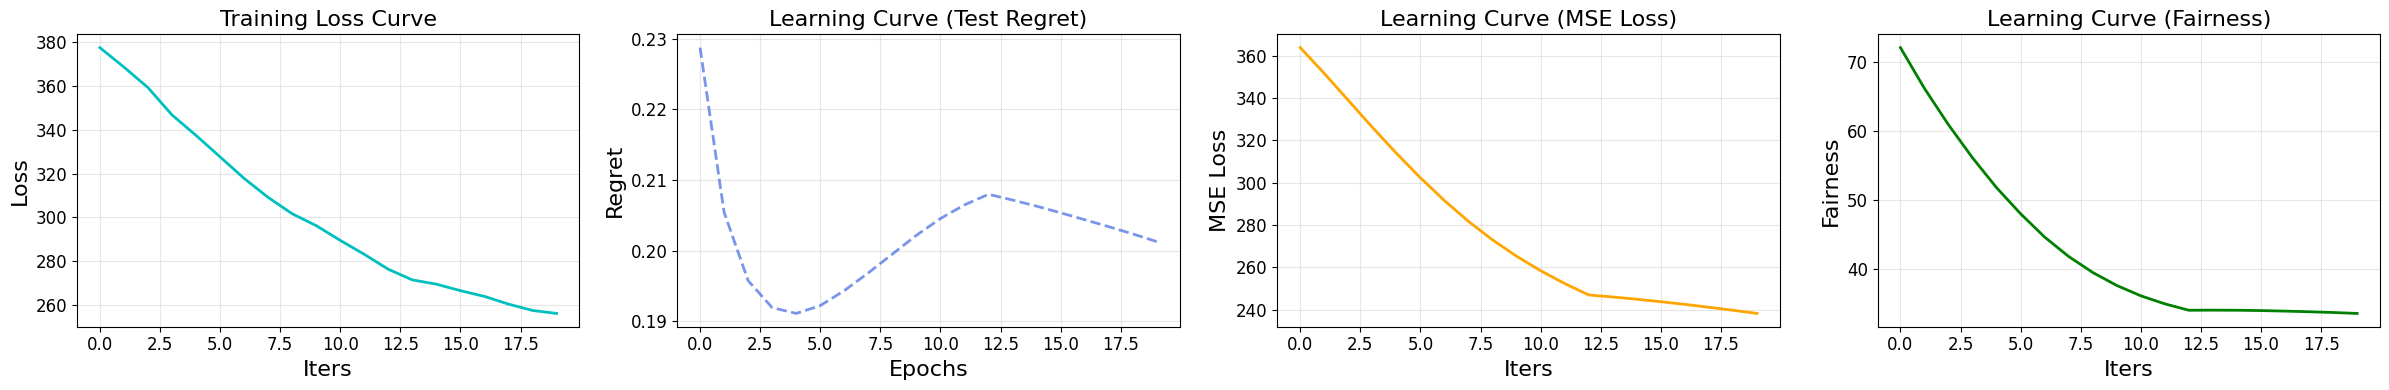

In [47]:

# alpha = 2
hyperparams = {
    "alpha":2,
    "Q": 2500,
    "lambda_fair": 0,
    "fairness_type": "mad",
    "group": True,            # Set to True for group fairness, False for individual
    "grad_method": "closed-form",  # Options: 'closed-form' or 'finite-diff
    "num_epochs": 50,
    "batch_size": len(b_train),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "init_lr":0.005,
    "noise_std": 0.00,  # Standard deviation for noise in gradient
    'loss_type': 'mse',  # 'regret' for decision-focused loss, 'mse' for standard MSE
}

final_model, logs = train_model_regret(
    X_train=feats_train, y_train=b_train, race_train=race_train, cost_train=cost_train, gainF_train=gainF_train,
    X_test=feats_test, y_test=b_test, race_test=race_test, cost_test=cost_test, gainF_test=gainF_test,
    model_class=FairRiskPredictor,
    input_dim=feats_train.shape[1],
    **hyperparams
)
logs = logs["logs"]
visLearningCurve(logs["train_loss"],
                 logs["train_regret"],
                 logs["train_mse"],
                 logs["test_fairness"])

In [48]:
%%script echo skipping
# alpha = 2
hyperparams = {
    "alpha":2,
    "Q": 2500,
    "lambda_fair": 0,
    "fairness_type": "mad",
    "group": False,            # Set to True for group fairness, False for individual
    "grad_method": "finite-diff",  # Options: 'closed-form' or 'finite-diff
    "num_epochs": 80,
    "batch_size": len(b_train),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "init_lr":1e-2
    # "scheduler_patience":5
}

final_model, logs = train_model_regret(
    X_train=feats_train, y_train=b_train, race_train=race_train, cost_train=cost_train, gainF_train=gainF_train,
    X_test=feats_test, y_test=b_test, race_test=race_test, cost_test=cost_test, gainF_test=gainF_test,
    model_class=FairRiskPredictor,
    input_dim=feats_train.shape[1],
    **hyperparams
)

logs = logs["logs"]
# Visualise the averaged learning curves
visLearningCurve(logs["train_loss"],
                 logs["train_regret"],
                 logs["train_mse"],
                 logs["test_fairness"])

Couldn't find program: 'echo'


# GridSearch

In [49]:
%%script echo skipping

# ==================================================
# Grid Search Finished! Finite Diff
# Best Overall Test Regret: 0.0417
# Best Hyperparameters found:
#   init_lr: 0.01
#   weight_decay: 0.0001
#   dropout_rate: 0.4
#   noise_std: 0.01
#   clip_grad_norm: None
# ==================================================
# Grid Search Finished! Closed Form
# Best Overall Test Regret: 0.0559
# Best Hyperparameters found:
#   init_lr: 0.03
#   weight_decay: 0.0001
#   dropout_rate: 0.4
#   noise_std: 0.01
#   clip_grad_norm: None



# ===================================================================
# 1. DEFINE THE CURATED GRID SEARCH SPACE
# ===================================================================
# A reasonable search space focusing on the most impactful parameters.
param_grid = {
    'init_lr': [3e-2, 1e-2, 5e-3],
    'weight_decay': [1e-4],
    'dropout_rate': [0.4],
    'noise_std': [0.01, 0.02, 0.05],
    'clip_grad_norm': [None] # Test with and without gradient clipping
}

# Base hyperparameters that will not change during this search
base_hyperparams = {
    "alpha": 2,
    "Q": 2500,
    "lambda_fair": 0,
    "fairness_type": "mad",
    "group": False, # Set to False to test the individual case
    "grad_method": "closed-form",
    "num_epochs": 80, # Set high, let early stopping take care of it
    "early_stopping_patience": 15,
    "scheduler_patience": 7,
    "batch_size": len(b_train),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# ===================================================================
# 2. RUN THE GRID SEARCH
# ===================================================================
best_run_info = {
    'logs': None,
    'regret': float('inf'),
    'params': None
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
total_trials = len(param_combinations)

print(f"Starting Grid Search with {total_trials} trials...\n")

for i, params_to_tune in enumerate(param_combinations):
    # Combine base parameters with the current set from the grid
    current_hyperparams = {**base_hyperparams, **params_to_tune}

    print(f"--- [Trial {i+1}/{total_trials}] Running with: {params_to_tune} ---")

    try:
        # Call the updated training function
        _, results = train_model_regret(
            X_train=feats_train, y_train=b_train, race_train=race_train, cost_train=cost_train, gainF_train=gainF_train,
            X_test=feats_test, y_test=b_test, race_test=race_test, cost_test=cost_test, gainF_test=gainF_test,
            model_class=FairRiskPredictor,
            input_dim=feats_train.shape[1],
            **current_hyperparams
        )

        # Get the best test regret from this run (returned by the function)
        final_test_regret = results["best_test_regret"]
        print(f"--- Trial {i+1} finished. Best Test Regret in this run: {final_test_regret:.4f} ---\n")

        # Check if this run is the best so far
        if final_test_regret < best_run_info['regret']:
            best_run_info['regret'] = final_test_regret
            best_run_info['logs'] = results["logs"]
            best_run_info['params'] = current_hyperparams

    except Exception as e:
        print(f"--- Trial {i+1} failed with error: {e} ---\n")

# ===================================================================
# 3. REPORT AND PLOT THE BEST RESULT
# ===================================================================
print("="*50)
print("Grid Search Finished!")
if best_run_info['params']:
    print(f"Best Overall Test Regret: {best_run_info['regret']:.4f}")
    print("Best Hyperparameters found:")
    # Print only the parameters that were tuned
    for key in param_grid.keys():
        print(f"  {key}: {best_run_info['params'].get(key)}")
    print("="*50)

    # Generate plots only for the best performing model
    best_logs = best_run_info['logs']
    print("Generating learning curve plots for the best model...")
    # This call matches your original request
    visLearningCurve(best_logs["train_loss"],
                     best_logs["train_regret"],
                     best_logs["test_mse"],
                     best_logs["test_fairness"])
else:
    print("No successful runs completed.")

Couldn't find program: 'echo'


In [50]:
%%script echo skipping

# ===================================================================
# 1. DEFINE THE CURATED GRID SEARCH SPACE
# ===================================================================
# A reasonable search space focusing on the most impactful parameters.
param_grid = {
    'init_lr': [3e-2, 1e-2, 1e-3],
    'weight_decay': [1e-4],
    'dropout_rate': [0.4],
    'noise_std': [0.0, 0.01],
    'clip_grad_norm': [None, 1.0] # Test with and without gradient clipping
}

# Base hyperparameters that will not change during this search
base_hyperparams = {
    "alpha": 2,
    "Q": 2500,
    "lambda_fair": 0,
    "fairness_type": "mad",
    "group": True, # Set to False to test the individual case
    "grad_method": "finite-diff",
    "num_epochs": 80, # Set high, let early stopping take care of it
    "early_stopping_patience": 15,
    "scheduler_patience": 7,
    "batch_size": len(b_train),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# ===================================================================
# 2. RUN THE GRID SEARCH
# ===================================================================
best_run_info = {
    'logs': None,
    'regret': float('inf'),
    'params': None
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
total_trials = len(param_combinations)

print(f"Starting Grid Search with {total_trials} trials...\n")

for i, params_to_tune in enumerate(param_combinations):
    # Combine base parameters with the current set from the grid
    current_hyperparams = {**base_hyperparams, **params_to_tune}

    print(f"--- [Trial {i+1}/{total_trials}] Running with: {params_to_tune} ---")

    try:
        # Call the updated training function
        _, results = train_model_regret(
            X_train=feats_train, y_train=b_train, race_train=race_train, cost_train=cost_train, gainF_train=gainF_train,
            X_test=feats_test, y_test=b_test, race_test=race_test, cost_test=cost_test, gainF_test=gainF_test,
            model_class=FairRiskPredictor,
            input_dim=feats_train.shape[1],
            **current_hyperparams
        )

        # Get the best test regret from this run (returned by the function)
        final_test_regret = results["best_test_regret"]
        print(f"--- Trial {i+1} finished. Best Test Regret in this run: {final_test_regret:.4f} ---\n")

        # Check if this run is the best so far
        if final_test_regret < best_run_info['regret']:
            best_run_info['regret'] = final_test_regret
            best_run_info['logs'] = results["logs"]
            best_run_info['params'] = current_hyperparams

    except Exception as e:
        print(f"--- Trial {i+1} failed with error: {e} ---\n")

# ===================================================================
# 3. REPORT AND PLOT THE BEST RESULT
# ===================================================================
print("="*50)
print("Grid Search Finished!")
if best_run_info['params']:
    print(f"Best Overall Test Regret: {best_run_info['regret']:.4f}")
    print("Best Hyperparameters found:")
    # Print only the parameters that were tuned
    for key in param_grid.keys():
        print(f"  {key}: {best_run_info['params'].get(key)}")
    print("="*50)

    # Generate plots only for the best performing model
    best_logs = best_run_info['logs']
    print("Generating learning curve plots for the best model...")
    # This call matches your original request
    visLearningCurve(best_logs["train_loss"],
                     best_logs["train_regret"],
                     best_logs["test_mse"],
                     best_logs["test_fairness"])
else:
    print("No successful runs completed.")

Couldn't find program: 'echo'


# Run Multi-Trial

In [51]:
def train_many_trials_regret(n_trials=10, base_seed=2025, **train_args):
    """
    Run `train_model_regret` for `n_trials`, now aggregating per-group metrics.
    """
    per_trial_metrics = defaultdict(list)
    final_model = None

    for t in range(n_trials):
        seed = base_seed + t
        torch.manual_seed(seed)
        np.random.seed(seed)

        final_model, results = train_model_regret(**train_args)
        logs = results.get("logs", {})

        if logs and logs.get('test_regret'):
            # --- Log overall metrics from the final epoch ---
            per_trial_metrics['regret'].append(logs['test_regret'][-1])
            per_trial_metrics['mse'].append(logs['test_mse'][-1])
            per_trial_metrics['fairness'].append(logs['test_fairness'][-1])
            per_trial_metrics['training_time'].append(results.get('training_time', 0))

            # --- KEY CHANGE: Log per-group metrics from the final epoch with the corrected key ---
            if logs['test_per_group_mse']:
                final_group_mse = logs['test_per_group_mse'][-1]
                for g_id, g_val in final_group_mse.items():
                    per_trial_metrics[f'G{int(g_id)}_mse'].append(g_val)

            if logs['test_per_group_fairness']:
                final_group_fairness = logs['test_per_group_fairness'][-1]
                for g_id, g_val in final_group_fairness.items():
                    per_trial_metrics[f'G{int(g_id)}_fairness'].append(g_val)

            if logs['test_per_group_objective']:
                final_group_obj = logs['test_per_group_objective'][-1]
                for g_id, g_val in final_group_obj.items():
                    per_trial_metrics[f'G{int(g_id)}_objective'].append(g_val)
        else:
            print(f"Warning: Trial {t+1} did not produce valid logs.")

    # --- Aggregation logic remains the same ---
    avg_results = {}
    print("\n" + "="*60)
    print("      AVERAGED RESULTS ACROSS ALL TRIALS")
    print("="*60)
    for key, values in per_trial_metrics.items():
        if values:
            μ, sigma = np.mean(values), np.std(values)
            avg_results[key] = μ
            avg_results[f'{key}_std'] = sigma
            print(f"[{key.upper():>25s}]  μ = {μ:.4f} | σ = {sigma:.4f}")
        else:
            avg_results[key] = np.nan
            avg_results[f'{key}_std'] = np.nan

    return avg_results, final_model

# Run Training

## Predictor = NN

In [52]:

@dataclass
class ExperimentConfig:
    """A dataclass to hold all experiment settings for easy management."""
    # Parameters to iterate over
    alphas: List[float] = field(default_factory=lambda: [0.5, 2.0])
    group_settings: List[bool] = field(default_factory=lambda: [True, False])
    grad_methods: List[str] = field(default_factory=lambda: ['closed-form', 'finite-diff'])
    fairness_types: List[str] = field(default_factory=lambda: ['atkinson', 'mad'])

    # Static problem parameters
    Q: int = 2500
    num_epochs: int = 50
    n_trials: int = 5

    # Best hyperparameters found from grid search
    best_hparams: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {
        'finite-diff': {
            'init_lr': 0.01, 'weight_decay': 1e-4, 'dropout_rate': 0.4,
            'noise_std': 0, 'clip_grad_norm': None
        },
        'closed-form': {
            'init_lr': 0.01, 'weight_decay': 1e-4, 'dropout_rate': 0.4,
            'noise_std': 0.00, 'clip_grad_norm': None
        }
    })

    def get_fairness_lambdas(self, fairness_type: str) -> List[float]:
        """Returns the lambdas for a given fairness type."""
        if fairness_type == 'atkinson':
            return [0, 1, 5]
        if fairness_type == 'mad':
            return [0, 0.05, 0.5]
        return [0]

# ===================================================================
# 2. RESULTS PROCESSING FUNCTION: Separate data wrangling
# ===================================================================
def process_and_display_results(results_df: pd.DataFrame):
    """Renames, reorders, and prints the final results DataFrame."""
    # 1. Rename columns for clarity in the final table
    rename_map = {
        'regret': 'Decision Regret mean', 'mse': 'Prediction MSE mean',
        'fairness': 'Prediction Fairness mean', 'fairness_std': 'Prediction Fairness std',
        'mse_std': 'Prediction MSE std', 'regret_std': 'Decision Regret std',
        'training_time': 'Training Time mean', 'training_time_std': 'Training Time std',
        'G0_mse': 'G0 MSE', 'G0_fairness': 'G0 Fairness', 'G0_objective': 'G0 Objective',
        'G1_mse': 'G1 MSE', 'G1_fairness': 'G1 Fairness', 'G1_objective': 'G1 Objective'
    }
    results_df.rename(columns=rename_map, inplace=True)

    # 2. Define the desired column order
    primary_cols = [
        'Group', 'Grad Method', 'Alpha', 'Lambda', 'Fairness',
        'Decision Regret mean', 'Prediction MSE mean', 'Prediction Fairness mean', 'Training Time mean'
    ]
    # Automatically find all other columns (like standard deviations)
    existing_primary_cols = [col for col in primary_cols if col in results_df.columns]
    other_cols = sorted([c for c in results_df.columns if c not in existing_primary_cols])

    # 3. Apply the new column order
    results_df = results_df[existing_primary_cols + other_cols]

    # --- Final Printout ---
    print("\n" + "="*90)
    print("                           EXPERIMENTS COMPLETE")
    print("="*90)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1200):
        print(results_df)

# ===================================================================
# 3. MAIN EXECUTION FUNCTION: Clean and focused harness
# ===================================================================
def run_experiments(config: ExperimentConfig):
    """Executes the main experiment loop based on the provided configuration."""
    results_list = []

    # Generate all combinations of the main experiment parameters
    experiment_params = list(itertools.product(
        config.group_settings, config.grad_methods, config.fairness_types, config.alphas
    ))

    for group, grad_method, fairness, alpha in experiment_params:
        fairness_lambdas = config.get_fairness_lambdas(fairness)
        for lam in fairness_lambdas:
            run_params = {
                'Group': group, 'Grad Method': grad_method, 'Alpha': alpha,
                'Lambda': lam, 'Fairness': fairness
            }
            print("\n" + "-"*70)
            print(f"RUNNING EXPERIMENT: {run_params}")
            print("-"*70)

            selected_hparams = config.best_hparams[grad_method]
            train_args = dict(
                X_train=feats_train, y_train=b_train, race_train=race_train,
                cost_train=cost_train, gainF_train=gainF_train,
                X_test=feats_test,  y_test=b_test,  race_test=race_test,
                cost_test=cost_test, gainF_test=gainF_test,
                model_class=FairRiskPredictor,
                input_dim=feats_train.shape[1],
                alpha=alpha, Q=config.Q,
                lambda_fair=lam, fairness_type=fairness,
                group=group, grad_method=grad_method,
                num_epochs=config.num_epochs,
                print_results=False, loss_type='mse',
                **selected_hparams
            )

            avg_results, _ = train_many_trials_regret(n_trials=config.n_trials, **train_args)
            row = {**run_params, **avg_results}
            results_list.append(row)

    results_df = pd.DataFrame(results_list)
    process_and_display_results(results_df)

# # ===================================================================
# # 4. SCRIPT ENTRY POINT
# # ===================================================================
# if __name__ == '__main__':
#     # Create a configuration object
#     exp_config = ExperimentConfig()

#     # You can easily modify the config for a specific run, for example:
#     # exp_config.group_settings = [False]
#     # exp_config.grad_methods = ['finite-diff']

#     # Run the experiments
#     run_experiments(exp_config)



## Predictor = LR

In [53]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:

@dataclass
class ExperimentConfig:
    """A dataclass to hold all experiment settings for easy management."""
    # Parameters to iterate over
    alphas: List[float] = field(default_factory=lambda:  [0.5, 2.0])
    group_settings: List[bool] = field(default_factory=lambda: [True, False])
    grad_methods: List[str] = field(default_factory=lambda: ['closed-form', 'finite-diff'])
    fairness_types: List[str] = field(default_factory=lambda: ['atkinson', 'mad'])

    # Static problem parameters
    Q: int = 2500
    num_epochs: int = 80
    n_trials: int = 5

    # Best hyperparameters found from grid search
    best_hparams: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {
        'finite-diff': {
            'init_lr': 0.01, 'weight_decay': 1e-4, 'dropout_rate': 0.4,
            'noise_std': 0, 'clip_grad_norm': None
        },
        'closed-form': {
            'init_lr': 0.03, 'weight_decay': 1e-4, 'dropout_rate': 0.4,
            'noise_std': 0.00, 'clip_grad_norm': None
        }
    })

    def get_fairness_lambdas(self, fairness_type: str) -> List[float]:
        """Returns the lambdas for a given fairness type."""
        if fairness_type == 'atkinson':
            return [0, 1, 5]
        if fairness_type == 'mad':
            return [0, 0.05, 0.5]
        return [0]

# ===================================================================
# 2. RESULTS PROCESSING FUNCTION: Separate data wrangling
# ===================================================================
def process_and_display_results(results_df: pd.DataFrame):
    """Renames, reorders, and prints the final results DataFrame."""
    # 1. Rename columns for clarity in the final table
    rename_map = {
        'regret': 'Decision Regret mean', 'mse': 'Prediction MSE mean',
        'fairness': 'Prediction Fairness mean', 'fairness_std': 'Prediction Fairness std',
        'mse_std': 'Prediction MSE std', 'regret_std': 'Decision Regret std',
        'training_time': 'Training Time mean', 'training_time_std': 'Training Time std',
        'G0_mse': 'G0 MSE', 'G0_fairness': 'G0 Fairness', 'G0_objective': 'G0 Objective',
        'G1_mse': 'G1 MSE', 'G1_fairness': 'G1 Fairness', 'G1_objective': 'G1 Objective'
    }
    results_df.rename(columns=rename_map, inplace=True)

    # 2. Define the desired column order
    primary_cols = [
        'Group', 'Grad Method', 'Alpha', 'Lambda', 'Fairness',
        'Decision Regret mean', 'Prediction MSE mean', 'Prediction Fairness mean', 'Training Time mean'
    ]
    # Automatically find all other columns (like standard deviations)
    existing_primary_cols = [col for col in primary_cols if col in results_df.columns]
    other_cols = sorted([c for c in results_df.columns if c not in existing_primary_cols])

    # 3. Apply the new column order
    results_df = results_df[existing_primary_cols + other_cols]

    # --- Final Printout ---
    print("\n" + "="*90)
    print("                           EXPERIMENTS COMPLETE")
    print("="*90)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1200):
        print(results_df)

# ===================================================================
# 3. MAIN EXECUTION FUNCTION: Clean and focused harness
# ===================================================================
def run_experiments(config: ExperimentConfig):
    """Executes the main experiment loop based on the provided configuration."""
    results_list = []

    # Generate all combinations of the main experiment parameters
    experiment_params = list(itertools.product(
        config.group_settings, config.grad_methods, config.fairness_types, config.alphas
    ))

    for group, grad_method, fairness, alpha in experiment_params:
        fairness_lambdas = config.get_fairness_lambdas(fairness)
        for lam in fairness_lambdas:
            run_params = {
                'Group': group, 'Grad Method': grad_method, 'Alpha': alpha,
                'Lambda': lam, 'Fairness': fairness
            }
            print("\n" + "-"*70)
            print(f"RUNNING EXPERIMENT: {run_params}")
            print("-"*70)

            selected_hparams = config.best_hparams[grad_method]
            train_args = dict(
                X_train=feats_train, y_train=b_train, race_train=race_train,
                cost_train=cost_train, gainF_train=gainF_train,
                X_test=feats_test,  y_test=b_test,  race_test=race_test,
                cost_test=cost_test, gainF_test=gainF_test,
                model_class=LinearRegressionModel,
                input_dim=feats_train.shape[1],
                alpha=alpha, Q=config.Q,
                lambda_fair=lam, fairness_type=fairness,
                group=group, grad_method=grad_method,
                num_epochs=config.num_epochs,
                print_results=False,
                **selected_hparams
            )

            avg_results, _ = train_many_trials_regret(n_trials=config.n_trials, **train_args)
            row = {**run_params, **avg_results}
            results_list.append(row)

    results_df_lr = pd.DataFrame(results_list)
    process_and_display_results(results_df_lr)

# ===================================================================
# 4. SCRIPT ENTRY POINT
# ===================================================================
if __name__ == '__main__':
    # Create a configuration object
    exp_config = ExperimentConfig()

    # You can easily modify the config for a specific run, for example:
    # exp_config.group_settings = [False]
    # exp_config.grad_methods = ['finite-diff']

    # Run the experiments
    run_experiments(exp_config)


# Results

In [56]:

@dataclass
class ExperimentConfig:
    """A dataclass to hold all experiment settings for easy management."""
    # Parameters to iterate over
    alphas: List[float] = field(default_factory=lambda: [0.5, 2.0])
    group_settings: List[bool] = field(default_factory=lambda: [True, False])
    grad_methods: List[str] = field(default_factory=lambda: ['closed-form', 'finite-diff'])
    fairness_types: List[str] = field(default_factory=lambda: ['atkinson', 'mad'])

    # Static problem parameters
    Q: int = 2500
    num_epochs: int = 3
    n_trials: int = 3

    # Best hyperparameters found from grid search
    best_hparams: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {
        'finite-diff': {
            'init_lr': 0.01, 'weight_decay': 1e-4, 'dropout_rate': 0.4,
            'noise_std': 0, 'clip_grad_norm': None
        },
        'closed-form': {
            'init_lr': 0.01, 'weight_decay': 1e-4, 'dropout_rate': 0.4,
            'noise_std': 0.00, 'clip_grad_norm': None
        }
    })

    def get_fairness_lambdas(self, fairness_type: str) -> List[float]:
        """Returns the lambdas for a given fairness type."""
        if fairness_type == 'atkinson':
            return [0, 1, 5]
        if fairness_type == 'mad':
            return [0, 0.05, 0.5]
        return [0]

# ===================================================================
# 2. RESULTS PROCESSING FUNCTION: Separate data wrangling
# ===================================================================
def process_and_display_results(results_df: pd.DataFrame):
    """Renames, reorders, and prints the final results DataFrame."""
    # 1. Rename columns for clarity in the final table
    rename_map = {
        'regret': 'Decision Regret mean', 'mse': 'Prediction MSE mean',
        'fairness': 'Prediction Fairness mean', 'fairness_std': 'Prediction Fairness std',
        'mse_std': 'Prediction MSE std', 'regret_std': 'Decision Regret std',
        'training_time': 'Training Time mean', 'training_time_std': 'Training Time std',
        'G0_mse': 'G0 MSE', 'G0_fairness': 'G0 Fairness', 'G0_objective': 'G0 Objective',
        'G1_mse': 'G1 MSE', 'G1_fairness': 'G1 Fairness', 'G1_objective': 'G1 Objective'
    }
    results_df.rename(columns=rename_map, inplace=True)

    # 2. Define the desired column order
    primary_cols = [
        'Group', 'Grad Method', 'Alpha', 'Lambda', 'Fairness',
        'Decision Regret mean', 'Prediction MSE mean', 'Prediction Fairness mean', 'Training Time mean'
    ]
    # Automatically find all other columns (like standard deviations)
    existing_primary_cols = [col for col in primary_cols if col in results_df.columns]
    other_cols = sorted([c for c in results_df.columns if c not in existing_primary_cols])

    # 3. Apply the new column order
    results_df = results_df[existing_primary_cols + other_cols]

    # --- Final Printout ---
    print("\n" + "="*90)
    print("                           EXPERIMENTS COMPLETE")
    print("="*90)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1200):
        print(results_df)

# ===================================================================
# 3. MAIN EXECUTION FUNCTION: Clean and focused harness
# ===================================================================
def run_experiments(config: ExperimentConfig):
    """Executes the main experiment loop based on the provided configuration."""
    results_list = []

    # Generate all combinations of the main experiment parameters
    experiment_params = list(itertools.product(
        config.group_settings, config.grad_methods, config.fairness_types, config.alphas
    ))

    for group, grad_method, fairness, alpha in experiment_params:
        fairness_lambdas = config.get_fairness_lambdas(fairness)
        for lam in fairness_lambdas:
            run_params = {
                'Group': group, 'Grad Method': grad_method, 'Alpha': alpha,
                'Lambda': lam, 'Fairness': fairness
            }
            print("\n" + "-"*70)
            print(f"RUNNING EXPERIMENT: {run_params}")
            print("-"*70)

            selected_hparams = config.best_hparams[grad_method]
            train_args = dict(
                X_train=feats_train, y_train=b_train, race_train=race_train,
                cost_train=cost_train, gainF_train=gainF_train,
                X_test=feats_test,  y_test=b_test,  race_test=race_test,
                cost_test=cost_test, gainF_test=gainF_test,
                model_class=FairRiskPredictor,
                input_dim=feats_train.shape[1],
                alpha=alpha, Q=config.Q,
                lambda_fair=lam, fairness_type=fairness,
                group=group, grad_method=grad_method,
                num_epochs=config.num_epochs,
                print_results=False, loss_type='mse',
                **selected_hparams
            )

            avg_results, _ = train_many_trials_regret(n_trials=config.n_trials, **train_args)
            row = {**run_params, **avg_results}
            results_list.append(row)

    results_df = pd.DataFrame(results_list)
    process_and_display_results(results_df)

    return results_df

# ===================================================================
# 4. SCRIPT ENTRY POINT
# ===================================================================
if __name__ == '__main__':
    # Create a configuration object
    exp_config = ExperimentConfig()

    # You can easily modify the config for a specific run, for example:
    # exp_config.group_settings = [False]
    # exp_config.grad_methods = ['finite-diff']

    # Run the experiments
    results = run_experiments(exp_config)




----------------------------------------------------------------------
RUNNING EXPERIMENT: {'Group': True, 'Grad Method': 'closed-form', 'Alpha': 0.5, 'Lambda': 0, 'Fairness': 'atkinson'}
----------------------------------------------------------------------
Training finished in 0.10s. Best Test Regret: 0.0616
Training finished in 0.20s. Best Test Regret: 0.0649
Training finished in 0.11s. Best Test Regret: 0.0677

      AVERAGED RESULTS ACROSS ALL TRIALS
[                   REGRET]  μ = 0.0695 | σ = 0.0018
[                      MSE]  μ = 291.3369 | σ = 11.2712
[                 FAIRNESS]  μ = 0.0036 | σ = 0.0004
[            TRAINING_TIME]  μ = 0.1354 | σ = 0.0459
[                   G0_MSE]  μ = 277.5706 | σ = 10.0275
[                   G1_MSE]  μ = 393.0595 | σ = 20.6027
[              G0_FAIRNESS]  μ = 0.6572 | σ = 0.0036
[              G1_FAIRNESS]  μ = 0.5594 | σ = 0.0051
[             G0_OBJECTIVE]  μ = 8.8785 | σ = 0.1748
[             G1_OBJECTIVE]  μ = 47.9480 | σ = 1.7769